In [38]:
import sklearn
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# 显示中文和负号
plt.rcParams["font.sans-serif"]=["Times New Roman"]
plt.rcParams["axes.unicode_minus"]=False

# 年龄预测建模详细流程

本流程包括以下主要步骤：

1. **数据预处理**：数据清洗、性别编码、特征与标签分离、训练集/测试集划分、标准化。
2. **特征选择（RFE）**：使用递归特征消除（RFE）方法进行特征选择，并可视化特征排名。
3. **多模型训练与超参数调优**：选择多种机器学习模型（如SVR、随机森林、岭回归、KNN等），通过GridSearchCV进行超参数调优。
4. **模型评估与对比**：输出各模型在测试集上的MAE和R2，选择最佳模型。
5. **最佳模型分析与解释**：包括模型保存、预测可视化、SHAP解释等。

每一步均配有相应代码和可视化结果，便于理解和复现。

In [39]:
data= pd.read_excel('T精细分型参考区间建立.xlsx')
data.dropna(inplace=True)
#将性别转换为0和1
data['Gender']=data['Gender'].map({'男':0,'女':1})
age=data['Age']
immunity=data.drop(columns=['Age','Date','Serial Number','Name'])

# 原始数据划分
X_train, X_test, y_train, y_test = train_test_split(immunity, age, test_size=0.2, random_state=42)

# 训练集标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 仅用训练集拟合
X_test_scaled = scaler.transform(X_test)      # 用训练集参数转换测试集


In [40]:
# Lasso特征选择及回归路径图
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import lasso_path

# LassoCV特征选择
lasso = LassoCV(cv=5, random_state=0, max_iter=100000, alphas=np.logspace(-3, 1, 50)).fit(X_train_scaled, y_train)
selected_features = X_train.columns[lasso.coef_ != 0]


c:\Users\Ryzen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.415823395903317, tolerance: 0.64108
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Ryzen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.30921814317162, tolerance: 0.64108
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Ryzen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0078167862288865, tolerance: 0.739195
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Ryzen\AppData\Local\Pro

c:\Users\Ryzen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1607.8152936517727, tolerance: 16.151500000000002
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Ryzen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3635.2966051970143, tolerance: 16.151500000000002
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\Ryzen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4738.092976419342, tolerance: 16.151500000000002
  model = cd_fast.enet_coordinate_descent_gram(

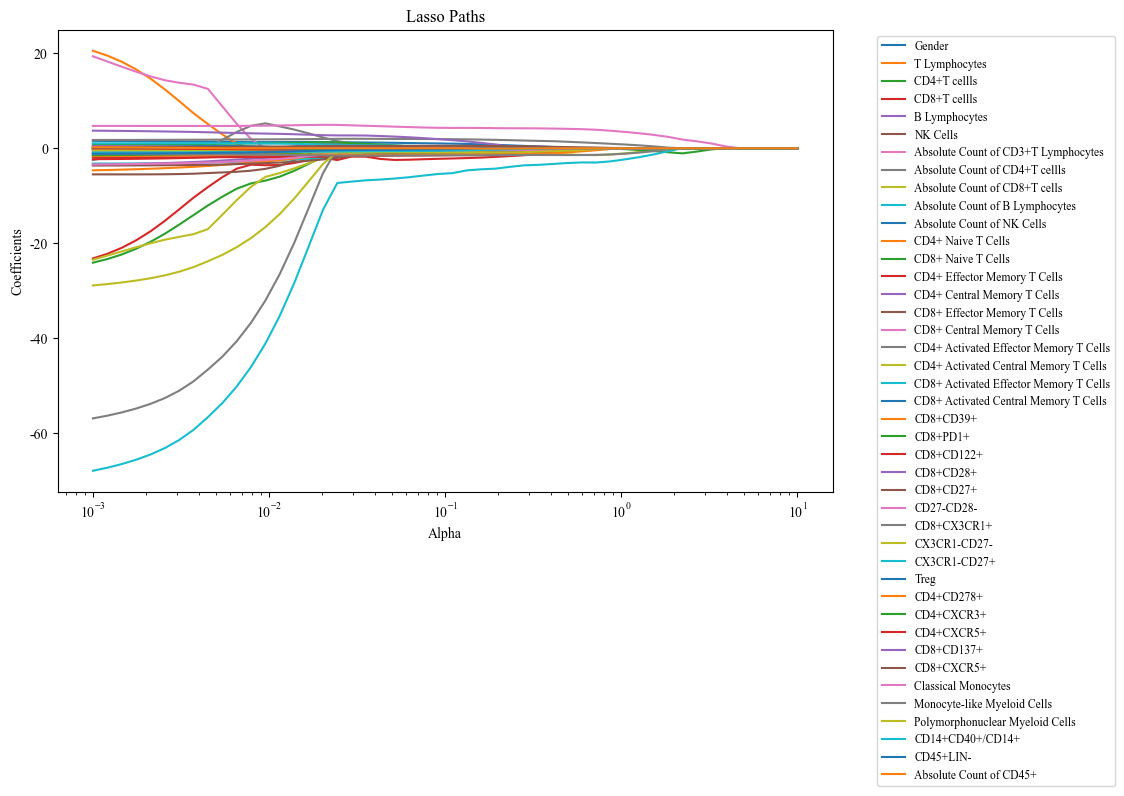

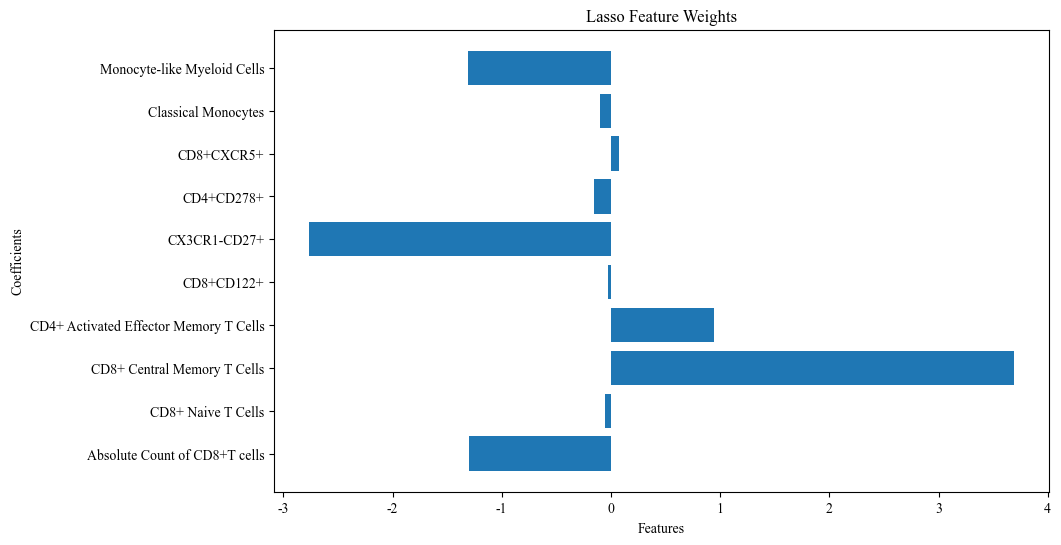

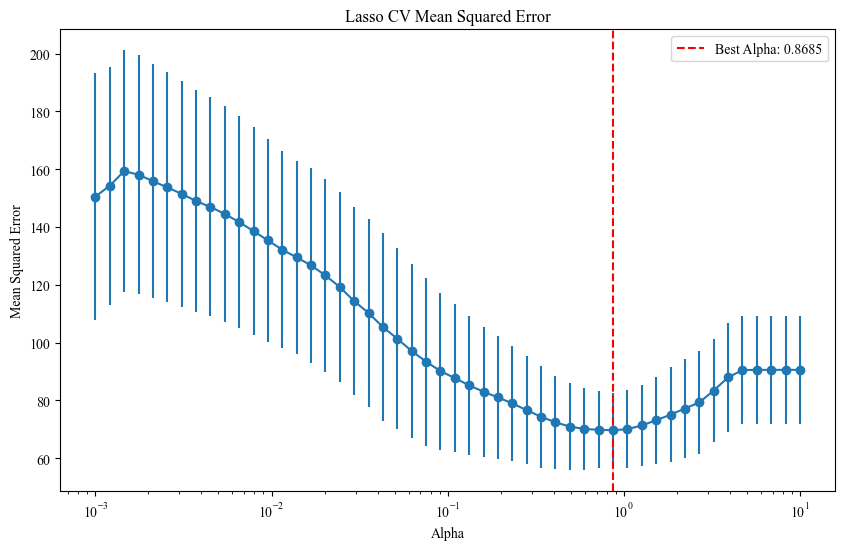

In [41]:
# Lasso回归路径图
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, alphas=np.logspace(-3, 1, 50))
plt.figure(figsize=(10, 6))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i], label=X_train.columns[i])
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()

#特征权重图
plt.figure(figsize=(10, 6))
plt.barh(selected_features, lasso.coef_[lasso.coef_ != 0])
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso Feature Weights')
plt.show()

# 画出CV过程中的平均绝对误差及标准差
plt.figure(figsize=(10, 6))
plt.errorbar(lasso.alphas_, lasso.mse_path_.mean(axis=1), yerr=lasso.mse_path_.std(axis=1), fmt='-o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso CV Mean Squared Error')
#标出最佳alpha
best_alpha = lasso.alpha_
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best Alpha: {best_alpha:.4f}')
plt.legend()
plt.show()


# 应用特征选择到标准化后的训练/测试集
X_train_final = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)[selected_features]
X_test_final = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)[selected_features]

scaler_final = StandardScaler()
X_train_final = scaler_final.fit_transform(X_train_final)
X_test_final = scaler_final.transform(X_test_final)


In [30]:
# 多模型训练与超参数调优
# 多模型训练与超参数调优
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# 定义模型及其参数空间
models = [
    ('SVR', SVR(), {
        'C': [0.1, 1, 10, 100],
        'epsilon': [0.01, 0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf', 'poly']
    }),
    ('RandomForest', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5]
    }),
    ('Ridge', Ridge(), {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    }),
    ('KNN', KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }),
    ('LinearReg', LinearRegression(), {}),  # 无需调参
    ('GBR', GradientBoostingRegressor(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5],
        'min_samples_split': [2, 4],
        'subsample': [0.8, 1.0]
    })
]

results = []

for name, model, params in models:
    if params:
        grid = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error')
        grid.fit(X_train_final, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_train_final, y_train)
    
    y_pred = best_model.predict(X_test_final)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({
        'Model': name,
        'BestParams': grid.best_params_ if params else 'None',
        'MAE': mae,
        'R2': r2
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values(by=['MAE', 'R2'], ascending=[True, False]))

# 选择最佳模型
best_row = results_df.sort_values(by=['MAE', 'R2'], ascending=[True, False]).iloc[0]
print(f"最佳模型: {best_row['Model']}，MAE: {best_row['MAE']:.2f}，R2: {best_row['R2']:.2f}")


,Model,BestParams,MAE,R2
5,GBR,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",6.247188,0.508531
1,RandomForest,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",6.320489,0.476656
4,LinearReg,None,6.431833,0.392904
2,Ridge,{'alpha': 10.0},6.528837,0.390759
0,SVR,"{'C': 1, 'epsilon': 0.01, 'kernel': 'linear'}",6.552448,0.407752
3,KNN,"{'n_neighbors': 9, 'weights': 'distance'}",6.929755,0.417754


最佳模型: GBR，MAE: 6.25，R2: 0.51


In [42]:
#训练最佳模型
model=GradientBoostingRegressor(learning_rate=0.05, max_depth=5, min_samples_split=2, n_estimators=200, subsample=0.8)
model.fit(X_train_final, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200,
                          subsample=0.8)

In [43]:
#存储该模型方便调用
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(scaler_final, 'scaler_final.pkl')

['scaler_final.pkl']

C:\Users\Ryzen\AppData\Local\Temp\ipykernel_20916\2040868714.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,c='red')


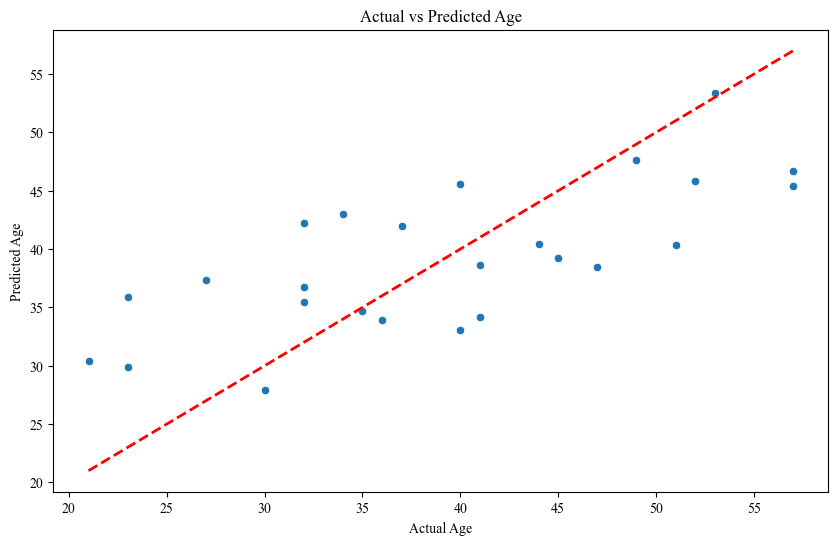

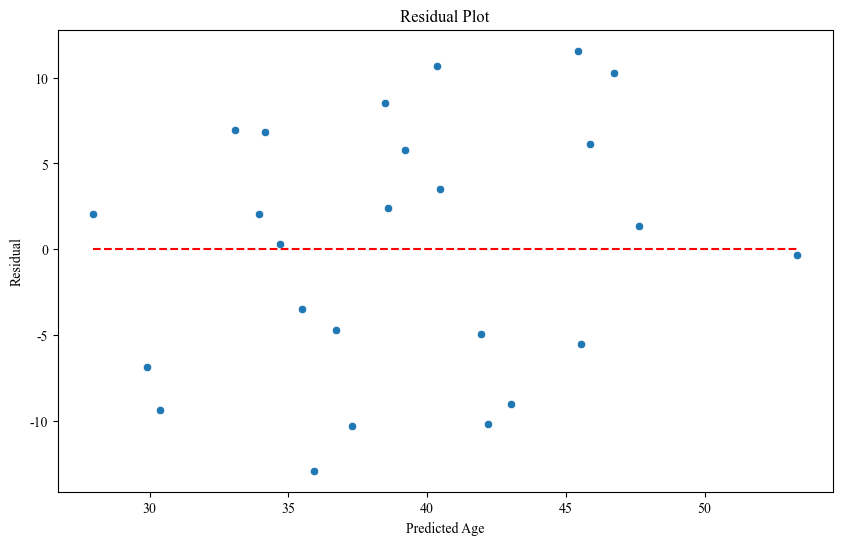

In [44]:
# 绘制预测结果与实际值的对比图
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2,c='red')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')
plt.show()
# 绘制残差图
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=y_test - y_pred)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Age')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.show()

In [45]:
selected_features

Index(['Absolute Count of CD8+T cells', 'CD8+ Naive T Cells',
       'CD8+ Central Memory T Cells', 'CD4+ Activated Effector Memory T Cells',
       'CD8+CD122+', 'CX3CR1-CD27+', 'CD4+CD278+', 'CD8+CXCR5+',
       'Classical Monocytes', 'Monocyte-like Myeloid Cells'],
      dtype='object')

In [46]:
#测试集中实例演示

y_pred = model.predict(X_test_final[0:10])
print("预测年龄:", y_pred)
print("实际年龄:", y_test[0:10].values)


预测年龄: [46.44844909 37.62541941 36.86942785 38.20925937 31.56683952 34.65972956
 35.75233984 42.87680584 44.05149688 34.92572216]
实际年龄: [57. 47. 27. 32. 21. 35. 41. 32. 37. 23.]


  0%|          | 0/25 [00:00<?, ?it/s]

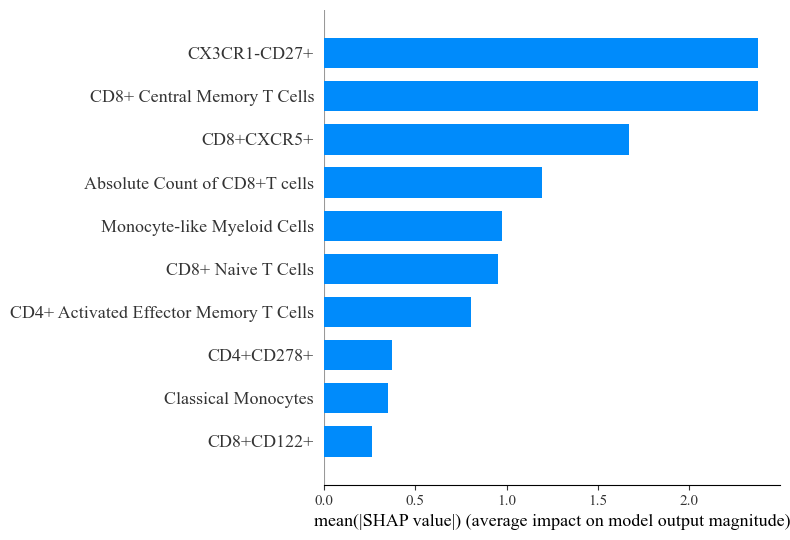

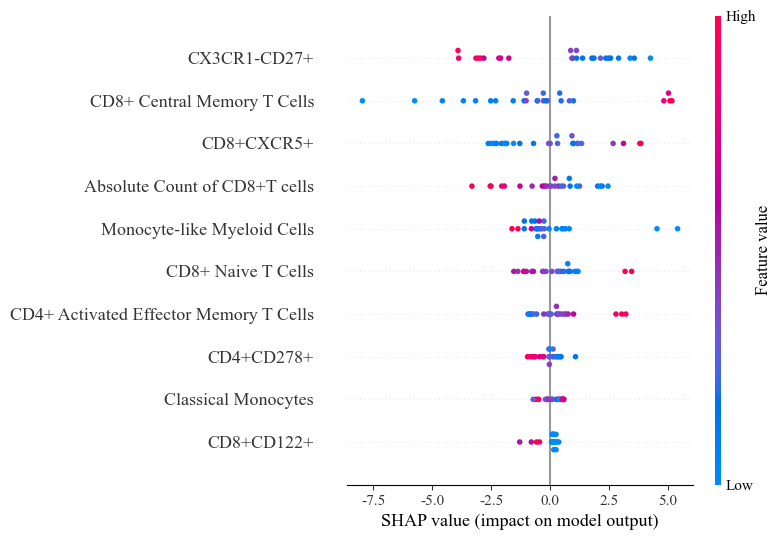

<Figure size 1000x400 with 0 Axes>

In [47]:
#使用shap解释模型

import shap
shap.initjs()
# 使用训练样本作为背景数据（加速计算）
background = shap.sample(X_train_final)

# 创建KernelExplainer
explainer = shap.KernelExplainer(model.predict, background)

# 计算SHAP值（建议先用少量测试样本）
shap_values = explainer.shap_values(X_test_final)  

# 绘制Summary Plot（特征重要性排序）
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_final, plot_type='bar', feature_names=selected_features)
plt.show()
shap.summary_plot(shap_values, X_test_final, feature_names=selected_features)
plt.show()

# 绘制Force Plot（单个样本预测解释）
plt.figure(figsize=(10, 4))
# 修改force_plot调用方式（需保持explainer和shap_values已计算）
shap.force_plot(explainer.expected_value, shap_values[0], X_test_final[0])




In [48]:
# 保存 SHAP 值和解释器依赖
import joblib

# 1. 保存模型（使用 joblib）
joblib.dump(model, 'model.pkl')

# 2. 保存背景数据（使用 numpy）
np.save('background.npy', background)

# 3. 保存 SHAP 值
np.save('shap_values.npy', shap_values)

print("SHAP values, model, and background data have been saved.")

SHAP values, model, and background data have been saved.
